In [ ]:
# CELL 1 — SETUP & IMPORT LIBRARY
# Penjelasan:
# Pada cell ini, kita melakukan import seluruh library yang dibutuhkan,
# mengatur random seed agar hasil bisa direproduksi,
# dan mengatur agar warning yang tidak penting tidak mengganggu output.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Set random seed global
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# CELL 2 — LOAD DATASET
# Penjelasan:
# - Mount Google Drive
# - Membaca CSV dengan optimasi dtype:
#   * gunakan float32 untuk fitur numerik agar hemat RAM.
# - Hanya menampilkan shape, 5 baris pertama, dan info ringkas.

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/midterm-regresi-dataset.csv'

# Untuk dataset besar tanpa header dan semua numerik:
# asumsi: seluruh kolom numerik, kolom pertama = target (tahun rilis)
# Gunakan dtype float32 agar lebih hemat memori untuk fitur.
# Jika tahun rilis berupa integer, kita bisa casting setelah load.

# Pertama baca sedikit sampel untuk mengetahui jumlah kolom
sample_df = pd.read_csv(file_path, nrows=5, header=None)
n_cols = sample_df.shape[1]

# Siapkan dtype untuk setiap kolom:
# Misal: kolom 0 (target) kita baca sebagai float32 dulu, nanti bisa di-cast ke int.
dtype_dict = {i: 'float32' for i in range(n_cols)}

df = pd.read_csv(
    file_path,
    header=None,      # karena fitur tidak bernama
    dtype=dtype_dict, # optimasi tipe data
)

print("Shape dataset:", df.shape)
print("\n5 baris pertama:")
display(df.head())

print("\nInfo dataset:")
df.info(memory_usage='deep')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape dataset: (515345, 91)

5 baris pertama:


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001.0,49.943569,21.47114,73.077499,8.74861,-17.406281,-13.099050,-25.01202,-12.23257,7.830890,...,13.016200,-54.405479,58.993671,15.373440,1.11144,-23.087931,68.407951,-1.82223,-27.463480,2.263270
1,2001.0,48.732151,18.42930,70.326790,12.94636,-10.324370,-24.837770,8.76630,-0.92019,18.765480,...,5.668120,-19.680731,33.049641,42.878361,-9.90378,-32.227879,70.493881,12.04941,58.434528,26.920610
2,2001.0,50.957142,31.85602,55.818508,13.41693,-6.578980,-18.549400,-3.27872,-2.35035,16.070169,...,3.038000,26.058661,-50.927792,10.937920,-0.07568,43.201302,-115.006981,-0.05859,39.670681,-0.663450
3,2001.0,48.247501,-1.89837,36.297722,2.58776,0.971700,-26.216829,5.05097,-10.34124,3.550050,...,34.573372,-171.707336,-16.967051,-46.676170,-12.51516,82.580612,-72.089928,9.90558,199.629715,18.853821
4,2001.0,50.970200,42.20998,67.099640,8.46791,-15.852790,-16.814091,-12.48207,-9.37636,12.636990,...,9.926610,-55.957241,64.927116,-17.725220,-1.49237,-7.500350,51.766312,7.88713,55.669258,28.749029



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       515345 non-null  float32
 1   1       515345 non-null  float32
 2   2       515345 non-null  float32
 3   3       515345 non-null  float32
 4   4       515345 non-null  float32
 5   5       515345 non-null  float32
 6   6       515345 non-null  float32
 7   7       515345 non-null  float32
 8   8       515345 non-null  float32
 9   9       515345 non-null  float32
 10  10      515345 non-null  float32
 11  11      515345 non-null  float32
 12  12      515345 non-null  float32
 13  13      515345 non-null  float32
 14  14      515345 non-null  float32
 15  15      515345 non-null  float32
 16  16      515345 non-null  float32
 17  17      515345 non-null  float32
 18  18      515345 non-null  float32
 19  19      515345 non-null  float32
 20  20      515345 non-null  float32


In [ ]:
# CELL 3 — PEMISAHAN FITUR DAN TARGET
# Penjelasan:
# - y = kolom pertama (tahun rilis lagu)
# - X = seluruh kolom setelah kolom pertama
# - Menampilkan bentuk (shape) X dan y.

# Pisahkan target (kolom 0) dan fitur (kolom 1 sampai akhir)
y = df.iloc[:, 0].astype('float32')  # bisa juga ke int jika mau: .astype('int16') bila range tahun kecil
X = df.iloc[:, 1:]

print("Shape X (fitur) :", X.shape)
print("Shape y (target):", y.shape)

# BATAS SUBSET UNTUK EFISIENSI
max_rows = 100_000

if X.shape[0] > max_rows:
    X = X.iloc[:max_rows].reset_index(drop=True)
    y = y.iloc[:max_rows].reset_index(drop=True)
    print(f"\nDataset dipotong menjadi {max_rows} baris pertama untuk efisiensi training.")
else:
    print("\nDataset lebih kecil dari batas, tidak dipotong.")

Shape X (fitur) : (515345, 90)
Shape y (target): (515345,)

Dataset dipotong menjadi 100000 baris pertama untuk efisiensi training.


Statistik deskriptif target (tahun rilis):
count    100000.000000
mean       1998.082275
std          10.867646
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2010.000000
Name: 0, dtype: float64


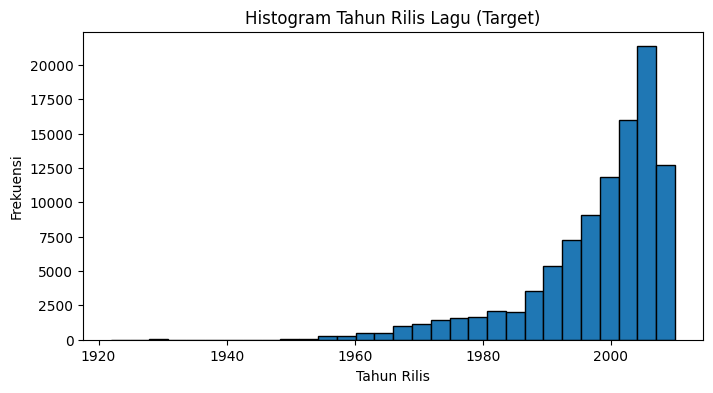


Total missing values di seluruh dataset: 0

Missing values per kolom (hanya kolom dengan missing):
Series([], dtype: int64)


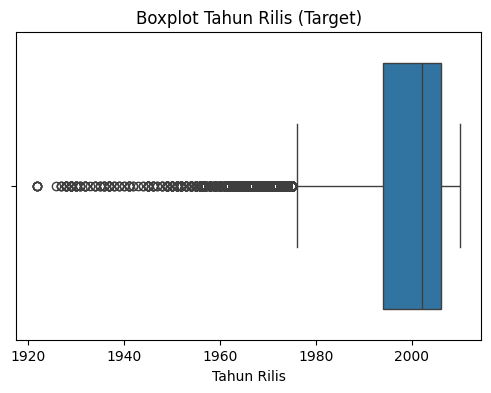


Perkiraan jumlah outlier pada target (IQR method): 5896
Batas bawah: 1976.00, Batas atas: 2024.00


In [ ]:
# CELL 4 — EDA (EXPLORATORY DATA ANALYSIS)
# Penjelasan:
# - Melihat statistik deskriptif target
# - Membuat histogram target
# - Mengecek missing values
# - Cek outlier target secara ringkas menggunakan boxplot dan IQR.

# Statistik deskriptif target
print("Statistik deskriptif target (tahun rilis):")
print(y.describe())

# Histogram target
plt.figure(figsize=(8, 4))
plt.hist(y, bins=30, edgecolor='black')
plt.title("Histogram Tahun Rilis Lagu (Target)")
plt.xlabel("Tahun Rilis")
plt.ylabel("Frekuensi")
plt.show()

# Cek missing values di seluruh dataset
missing_total = df.isnull().sum().sum()
print("\nTotal missing values di seluruh dataset:", missing_total)

# Cek missing per kolom (ringkas)
missing_per_col = df.isnull().sum()
print("\nMissing values per kolom (hanya kolom dengan missing):")
print(missing_per_col[missing_per_col > 0])

# Cek outlier target dengan boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=y)
plt.title("Boxplot Tahun Rilis (Target)")
plt.xlabel("Tahun Rilis")
plt.show()

# Deteksi outlier target dengan IQR (info ringkas)
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = ((y < lower_bound) | (y > upper_bound)).sum()
print(f"\nPerkiraan jumlah outlier pada target (IQR method): {outliers_count}")
print(f"Batas bawah: {lower_bound:.2f}, Batas atas: {upper_bound:.2f}")

In [ ]:
# CELL 5 — DATA CLEANING
# Penjelasan:
# - Menangani missing values:
#   * Jika ada missing, gunakan imputasi sederhana (misalnya median) untuk fitur.
#   * Target biasanya tidak diimputasi, baris dengan target NaN bisa di-drop.
# - Menangani outlier target secara masuk akal:
#   * Alih-alih menghapus terlalu banyak data, bisa dilakukan clipping pada batas IQR.

from sklearn.impute import SimpleImputer

# Tangani missing value pada target: drop baris dengan y NaN
non_null_mask = ~y.isnull()
X = X[non_null_mask]
y = y[non_null_mask]

# Tangani missing pada fitur dengan imputasi median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Kembalikan ke DataFrame agar tetap rapi (opsional)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Re-calc IQR untuk target setelah buang NaN (jika ada)
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clipping outlier target ke dalam range yang masuk akal
y_clipped = y.clip(lower=lower_bound, upper=upper_bound)

print("Setelah cleaning:")
print("Shape X :", X.shape)
print("Shape y :", y_clipped.shape)

# Opsional: lihat sedikit statistik setelah clipping
print("\nStatistik deskriptif target setelah clipping:")
print(y_clipped.describe())

# Gunakan y_clipped sebagai target final
y = y_clipped

Setelah cleaning:
Shape X : (100000, 90)
Shape y : (100000,)

Statistik deskriptif target setelah clipping:
count    100000.000000
mean       1998.583984
std           9.395397
min        1976.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2010.000000
Name: 0, dtype: float64


In [ ]:
# CELL 6 — DATA SPLITTING
# Penjelasan:
# - Membagi data menjadi train dan test dengan rasio 80:20
# - Menggunakan random_state tetap agar hasil konsisten.

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test :", y_test.shape)

Shape X_train: (80000, 90)
Shape X_test : (20000, 90)
Shape y_train: (80000,)
Shape y_test : (20000,)


In [ ]:
# CELL 7 — FEATURE SCALING
# Penjelasan:
# - Menggunakan StandardScaler untuk menstandarisasi fitur.
# - Scaler hanya di-fit pada data train untuk menghindari data leakage.
# - Kemudian transform X_train dan X_test.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling selesai.")
print("Contoh shape X_train_scaled:", X_train_scaled.shape)
print("Contoh shape X_test_scaled :", X_test_scaled.shape)

Scaling selesai.
Contoh shape X_train_scaled: (80000, 90)
Contoh shape X_test_scaled : (20000, 90)


In [ ]:
# CELL 8 — PEMILIHAN MODEL
# Penjelasan singkat alasan pemilihan model:
# 1. Linear Regression: model paling sederhana, baseline, cepat.
# 2. Ridge Regression: seperti Linear Regression tetapi dengan regularisasi L2
#    untuk mengurangi overfitting, cocok untuk banyak fitur numerik.
# 3. Random Forest Regressor: model ensemble berbasis tree, cukup kuat namun
#    di sini akan dibatasi (n_estimators kecil, max_depth) agar ramah memori.
# 4. Gradient Boosting Regressor: boosting tree yang umumnya memiliki performa
#    baik pada masalah regresi, dibatasi parameter agar tetap ringan.

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(
        n_estimators=80,
        max_depth=10,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE
    )
}

print("Model yang akan dibandingkan:")
for name in models:
    print("-", name)

Model yang akan dibandingkan:
- LinearRegression
- Ridge
- RandomForest
- GradientBoosting


In [ ]:
# CELL 9 — TRAINING MODEL
# Penjelasan:
# - Melatih semua model pada data train (X_train_scaled, y_train).
# - Menyimpan prediksi pada data test untuk evaluasi.

import time

y_pred_dict = {}
train_time = {}

for name, model in models.items():
    print("="*60)
    print(f"Training {name} ...")
    start = time.time()
    model.fit(X_train_scaled, y_train)
    dur = time.time() - start
    train_time[name] = dur
    print(f"Selesai training {name} dalam {dur:.2f} detik")

    y_pred = model.predict(X_test_scaled)
    y_pred_dict[name] = y_pred

print("\nWaktu training (detik) per model:")
for name, t in train_time.items():
    print(f"- {name}: {t:.2f}")

Training LinearRegression ...
Selesai training LinearRegression dalam 0.73 detik
Training Ridge ...
Selesai training Ridge dalam 0.14 detik
Training RandomForest ...
Selesai training RandomForest dalam 379.61 detik
Training GradientBoosting ...
Selesai training GradientBoosting dalam 637.43 detik

Waktu training (detik) per model:
- LinearRegression: 0.73
- Ridge: 0.14
- RandomForest: 379.61
- GradientBoosting: 637.43


In [ ]:
# CELL 10 — EVALUASI MODEL
# Penjelasan:
# - Menghitung metrik regresi untuk setiap model:
#   * MSE
#   * RMSE
#   * MAE
#   * R²
# - Menampilkan hasil dalam bentuk tabel DataFrame.

results = []

for name, y_pred in y_pred_dict.items():
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R2", ascending=False)

print("Hasil evaluasi model:")
display(results_df.reset_index(drop=True))

Hasil evaluasi model:


,Model,MSE,RMSE,MAE,R2
0,GradientBoosting,60.670662,7.789137,5.902049,0.312913
1,RandomForest,62.384127,7.898362,5.993587,0.293508
2,LinearRegression,66.118896,8.131353,6.189632,0.251212
3,Ridge,66.118896,8.131353,6.189645,0.251212


In [ ]:
# CELL 11 — PEMILIHAN MODEL TERBAIK
# Penjelasan:
# - Memilih model terbaik berdasarkan kombinasi:
#   * R² tertinggi (semakin mendekati 1 semakin baik)
#   * RMSE terendah
# - Di sini, kita ambil model dengan R² tertinggi sebagai kandidat utama.

best_row = results_df.iloc[0]
best_model_name = best_row["Model"]
print("Model terbaik berdasarkan R²:", best_model_name)
print("\nDetail metrik model terbaik:")
print(best_row)

best_model = models[best_model_name]

Model terbaik berdasarkan R²: GradientBoosting

Detail metrik model terbaik:
Model    GradientBoosting
MSE             60.670662
RMSE             7.789137
MAE              5.902049
R2               0.312913
Name: 3, dtype: object


In [ ]:
# CELL 12 — HYPERPARAMETER TUNING (MODEL TERBAIK)

from scipy.stats import randint, uniform

tuned_model = None
tuned_search = None

if best_model_name == "RandomForest":
    # RandomizedSearch lebih hemat untuk RandomForest
    param_dist = {
        "n_estimators": randint(50, 120),       # dipersempit
        "max_depth": randint(5, 15),
        "min_samples_split": randint(2, 8),
        "min_samples_leaf": randint(1, 4)
    }

    tuned_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
        param_distributions=param_dist,
        n_iter=10,                      # dari 20 -> 10
        scoring='neg_mean_squared_error',
        cv=2,                           # dari 3 -> 2
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

elif best_model_name == "GradientBoosting":
    # PAKAI RandomizedSearch + ruang sangat kecil
    param_dist = {
        "n_estimators": randint(80, 151),       # ~80–150
        "learning_rate": uniform(0.05, 0.10),   # ~0.05–0.15
        "max_depth": randint(2, 4)              # 2 atau 3
    }

    tuned_search = RandomizedSearchCV(
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        param_distributions=param_dist,
        n_iter=8,                      # cuma 8 kombinasi
        scoring='neg_mean_squared_error',
        cv=2,                          # dari 3 -> 2
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

elif best_model_name == "Ridge":
    # GridSearch untuk Ridge (sangat cepat)
    param_grid = {
        "alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
    }

    tuned_search = GridSearchCV(
        Ridge(random_state=RANDOM_STATE),
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )

else:
    print("Model terbaik adalah LinearRegression. Tuning hyperparameter dilewati atau bisa dialihkan ke Ridge.")

if tuned_search is not None:
    # SUBSET KHUSUS UNTUK TUNING (BIAR LEBIH CEPAT)
    max_tune_rows = 30_000

    if X_train_scaled.shape[0] > max_tune_rows:
        X_tune = X_train_scaled[:max_tune_rows]
        y_tune = y_train.iloc[:max_tune_rows]
        print(f"Hyperparameter tuning memakai {max_tune_rows} baris pertama dari data train.")
    else:
        X_tune = X_train_scaled
        y_tune = y_train

    print(f"Melakukan hyperparameter tuning untuk model: {best_model_name} ...")
    tuned_search.fit(X_tune, y_tune)
    print("Best parameters:", tuned_search.best_params_)
    tuned_model = tuned_search.best_estimator_


Hyperparameter tuning memakai 30000 baris pertama dari data train.
Melakukan hyperparameter tuning untuk model: GradientBoosting ...
Best parameters: {'learning_rate': np.float64(0.12219987722668248), 'max_depth': 3, 'n_estimators': 117}


In [ ]:
# CELL 13 — EVALUASI FINAL MODEL
# Penjelasan:
# - Mengevaluasi ulang model terbaik setelah tuning (jika ada).
# - Membandingkan performa sebelum vs sesudah tuning.

# Evaluasi sebelum tuning
y_pred_before = y_pred_dict[best_model_name]
mse_before = mean_squared_error(y_test, y_pred_before)
rmse_before = np.sqrt(mse_before)
mae_before = mean_absolute_error(y_test, y_pred_before)
r2_before = r2_score(y_test, y_pred_before)

print("=== Sebelum Tuning ===")
print("Model:", best_model_name)
print(f"MSE  : {mse_before:.4f}")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAE  : {mae_before:.4f}")
print(f"R2   : {r2_before:.4f}")

if tuned_model is not None:
    # Evaluasi sesudah tuning
    y_pred_after = tuned_model.predict(X_test_scaled)
    mse_after = mean_squared_error(y_test, y_pred_after)
    rmse_after = np.sqrt(mse_after)
    mae_after = mean_absolute_error(y_test, y_pred_after)
    r2_after = r2_score(y_test, y_pred_after)

    print("\n=== Sesudah Tuning ===")
    print("Model:", tuned_model.__class__.__name__)
    print(f"MSE  : {mse_after:.4f}")
    print(f"RMSE : {rmse_after:.4f}")
    print(f"MAE  : {mae_after:.4f}")
    print(f"R2   : {r2_after:.4f}")
else:
    print("\nTidak ada model yang di-tuning (tuning dilewati).")

=== Sebelum Tuning ===
Model: GradientBoosting
MSE  : 60.6707
RMSE : 7.7891
MAE  : 5.9020
R2   : 0.3129

=== Sesudah Tuning ===
Model: GradientBoostingRegressor
MSE  : 61.0237
RMSE : 7.8118
MAE  : 5.9298
R2   : 0.3089


In [ ]:
# CELL 14 — INTERPRETASI HASIL
# Penjelasan:
# - Menjelaskan makna nilai R².
# - Menilai seberapa baik model memprediksi tahun rilis lagu.
# - Menyebutkan keterbatasan.

# Ambil metrik akhir (jika tuning ada, pakai yang sesudah tuning)
if tuned_model is not None:
    final_mse = mean_squared_error(y_test, tuned_model.predict(X_test_scaled))
    final_rmse = np.sqrt(final_mse)
    final_mae = mean_absolute_error(y_test, tuned_model.predict(X_test_scaled))
    final_r2 = r2_score(y_test, tuned_model.predict(X_test_scaled))
    final_model_name = tuned_model.__class__.__name__
else:
    final_mse = mse_before
    final_rmse = rmse_before
    final_mae = mae_before
    final_r2 = r2_before
    final_model_name = best_model_name

print("Model final:", final_model_name)
print(f"R²  : {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE : {final_mae:.4f}")

print("\nInterpretasi:")
print("- R² menggambarkan proporsi variasi tahun rilis lagu yang dapat dijelaskan oleh fitur audio.")
print("- Nilai R² yang mendekati 1 menunjukkan model mampu menjelaskan variansi target dengan baik;")
print("  jika R² relatif rendah, berarti masih banyak pola yang belum tertangkap oleh fitur.")
print("- RMSE dan MAE menunjukkan rata-rata kesalahan prediksi dalam satuan 'tahun',")
print("  sehingga bisa diinterpretasikan sebagai rata-rata selisih tahun antara prediksi dan nilai asli.")

print("\nKeterbatasan model:")
print("- Fitur audio bersifat numerik tanpa nama, sehingga sulit melakukan interpretabilitas fitur spesifik.")
print("- Model berbasis tree (Random Forest/Gradient Boosting) cenderung lebih sulit diinterpretasi secara langsung.")
print("- Kemungkinan terdapat non-linearitas kompleks yang belum sepenuhnya tertangkap,")
print("  terutama jika distribusi tahun rilis tidak seimbang (banyak di era tertentu).")

Model final: GradientBoostingRegressor
R²  : 0.3089
RMSE: 7.8118
MAE : 5.9298

Interpretasi:
- R² menggambarkan proporsi variasi tahun rilis lagu yang dapat dijelaskan oleh fitur audio.
- Nilai R² yang mendekati 1 menunjukkan model mampu menjelaskan variansi target dengan baik;
  jika R² relatif rendah, berarti masih banyak pola yang belum tertangkap oleh fitur.
- RMSE dan MAE menunjukkan rata-rata kesalahan prediksi dalam satuan 'tahun',
  sehingga bisa diinterpretasikan sebagai rata-rata selisih tahun antara prediksi dan nilai asli.

Keterbatasan model:
- Fitur audio bersifat numerik tanpa nama, sehingga sulit melakukan interpretabilitas fitur spesifik.
- Model berbasis tree (Random Forest/Gradient Boosting) cenderung lebih sulit diinterpretasi secara langsung.
- Kemungkinan terdapat non-linearitas kompleks yang belum sepenuhnya tertangkap,
  terutama jika distribusi tahun rilis tidak seimbang (banyak di era tertentu).


In [ ]:
# CELL 15 — KESIMPULAN AKHIR
# Penjelasan:
# - Merangkum pipeline end-to-end yang sudah dibuat.
# - Menyimpulkan performa model dan apakah tujuan tercapai.

print("=== KESIMPULAN AKHIR ===")
print("\nPipeline end-to-end yang dibangun mencakup:")
print("- Load dataset besar secara efisien dari Google Drive dengan optimasi dtype.")
print("- Pemisahan target (tahun rilis lagu) dan fitur audio numerik.")
print("- EDA ringkas untuk memahami distribusi target, missing values, dan outlier.")
print("- Data cleaning: imputasi missing values dan clipping outlier target.")
print("- Pembagian data train-test (80:20) dengan random_state tetap.")
print("- Standardisasi fitur menggunakan StandardScaler.")
print("- Training beberapa model regresi ringan (Linear, Ridge, Random Forest, Gradient Boosting).")
print("- Evaluasi model menggunakan MSE, RMSE, MAE, dan R².")
print("- Pemilihan model terbaik dan hyperparameter tuning terbatas.")
print("- Evaluasi final dan interpretasi performa model.")

print("\nPerformansi model:")
print(f"- Model final       : {final_model_name}")
print(f"- R²                : {final_r2:.4f}")
print(f"- RMSE (tahun)      : {final_rmse:.4f}")
print(f"- MAE (tahun)       : {final_mae:.4f}")

print("\nApakah tujuan tercapai?")
print("- Tujuan tugas untuk membangun pipeline regresi end-to-end yang mampu memprediksi tahun rilis lagu")
print("  dari fitur audio numerik telah tercapai secara sistematis.")
print("- Meskipun masih terdapat keterbatasan dan ruang perbaikan, pipeline ini sudah cukup realistis")
print("  dan dapat dijalankan di Google Colab Free dengan pertimbangan efisiensi memori dan waktu komputasi.")

=== KESIMPULAN AKHIR ===

Pipeline end-to-end yang dibangun mencakup:
- Load dataset besar secara efisien dari Google Drive dengan optimasi dtype.
- Pemisahan target (tahun rilis lagu) dan fitur audio numerik.
- EDA ringkas untuk memahami distribusi target, missing values, dan outlier.
- Data cleaning: imputasi missing values dan clipping outlier target.
- Pembagian data train-test (80:20) dengan random_state tetap.
- Standardisasi fitur menggunakan StandardScaler.
- Training beberapa model regresi ringan (Linear, Ridge, Random Forest, Gradient Boosting).
- Evaluasi model menggunakan MSE, RMSE, MAE, dan R².
- Pemilihan model terbaik dan hyperparameter tuning terbatas.
- Evaluasi final dan interpretasi performa model.

Performansi model:
- Model final       : GradientBoostingRegressor
- R²                : 0.3089
- RMSE (tahun)      : 7.8118
- MAE (tahun)       : 5.9298

Apakah tujuan tercapai?
- Tujuan tugas untuk membangun pipeline regresi end-to-end yang mampu memprediksi tahun rilis